### В этом ноутбуке тренируется модель RetinaNet на COCO-Text/Train и сохраняется на жесткий диск.

In [1]:
from pathlib import Path
import numpy as np
import torch
import math
from tqdm import tqdm
from a4_course_cvdl_t3.coco_text import COCO_Text

In [2]:
base = Path(r"F:\bzimka\edu\data\coco_text")
anno_path = base / 'cocotext.v2.json'
images_path = base / 'train2014'

assert anno_path.exists(), "Set your own path to annotation"
assert images_path.exists(), "Set your own path to images"


СOCO_Text взят из репозитория авторов датасета
https://github.com/andreasveit/coco-text/

In [3]:
ct = COCO_Text(anno_path)

loading annotations into memory...
0:00:02.278038
creating index...
index created!


#### Пример работы из репозитория coco-text
Взято из 
https://github.com/andreasveit/coco-text/blob/master/coco_text_Demo.ipynb

In [4]:
# get all images containing at least one instance of legible text
imgIds = ct.getImgIds(imgIds=ct.train, 
                    catIds=[('legibility','legible')])
# pick one at random
img = ct.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

In [5]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)

Text(0.5, 1.0, 'Изображение из датасета COCO')

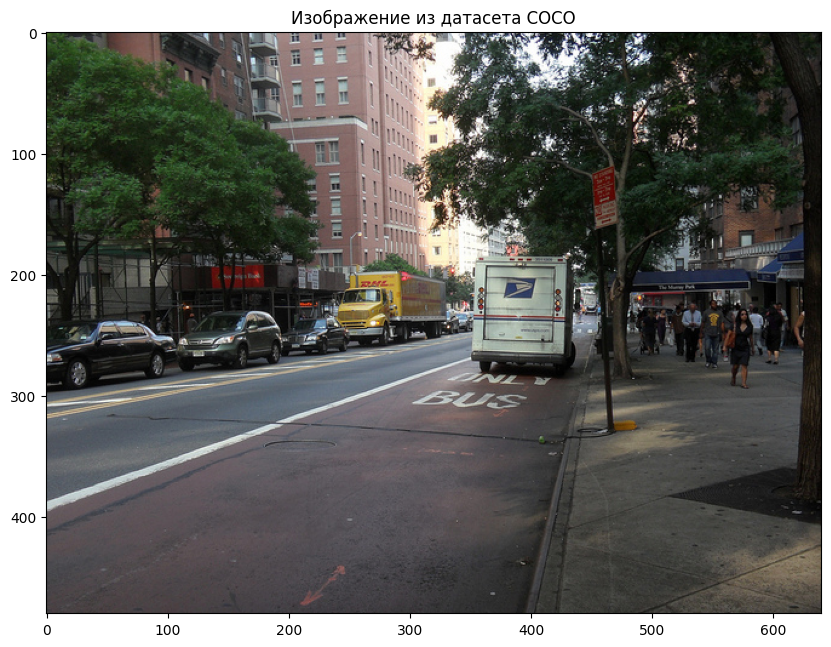

In [6]:
plt.imshow(plt.imread(images_path / img['file_name']))
plt.title("Изображение из датасета COCO")

Text(0.5, 1.0, 'Изображение с GT детекциями текста')

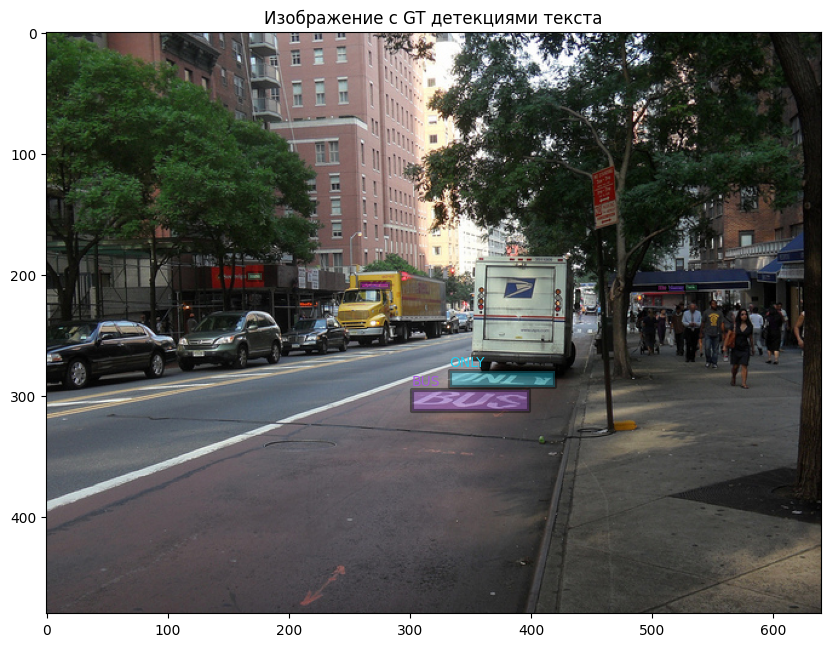

In [7]:
plt.imshow(plt.imread(images_path / img['file_name']))
annIds = ct.getAnnIds(imgIds=img['id'])
anns = ct.loadAnns(annIds)
ct.showAnns(anns)
plt.title("Изображение с GT детекциями текста")

### Подготовка датасетов

In [8]:
from a4_course_cvdl_t3.coco_text import COCO_Text
from a4_course_cvdl_t3 import coco_evaluation


In [9]:
from a4_course_cvdl_t2.impl.data import CocoTextDetection, CocoDetectionPrepareTransform


In [10]:
ds_train = CocoTextDetection(
    images_path,
    Path(anno_path),
    transforms=CocoDetectionPrepareTransform(size=(640, 640))
)

In [11]:
ds_val = CocoTextDetection(
    images_path,
    Path(anno_path),
    transforms=CocoDetectionPrepareTransform(size=(640, 640)),
    split='val'
)

In [12]:
trainloader = torch.utils.data.DataLoader(
    ds_train, batch_size=4, shuffle=True
)

In [13]:
valloader = torch.utils.data.DataLoader(
    ds_val, batch_size=1, shuffle=False
)

### Подготовка модели
Используется RetinaNet из torchvision

In [14]:
from torchvision.models.detection import RetinaNet
from torchvision.models.detection.anchor_utils import AnchorGenerator
from torchvision.models import mobilenet_v2

In [15]:
backbone = mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)
model = RetinaNet(backbone,
                  num_classes=2,
                  anchor_generator=anchor_generator)

C:\Users\bzimka\.conda\envs\openmmlab\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\bzimka\.conda\envs\openmmlab\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
def prepare(images_tensor, center_boxes, device):
    """
    Функция подготовки изображения и боксов для torchvision-RetinaNet:
    - разбивает тензор T[B,C, H W] в список тензоров List[T[C, H, W]]
    - переводит тензоры на device
    - переводит боксы из формата [xc, yc, wx, hy] в [xmin, ymin, xmax, ymax]
    - устанавливает label класс как 1 для всех боксов
    - убирает боксы-"заглушки", заполненные -1
    """
    list_center_boxes = list(x for x in center_boxes)
    list_images = list(x.to(device) for x in images_tensor)
    list_boxes = []
    for cb in list_center_boxes:
        real_cboxes = cb[cb[:, -1] > 0]
        real_boxes = torch.ones_like(real_cboxes)
        real_boxes[:, 1] = real_cboxes[:, 0] - real_cboxes[:, 2] / 2
        real_boxes[:, 3] = real_cboxes[:, 0] + real_cboxes[:, 2] / 2
        real_boxes[:, 0] = real_cboxes[:, 1] - real_cboxes[:, 3] / 2
        real_boxes[:, 2] = real_cboxes[:, 1] + real_cboxes[:, 3] / 2
        boxes, labels, prob_ones = torch.split(real_boxes, [4, 1, 1], dim=1)
        list_boxes.append({"boxes": boxes.to(device), "labels": labels.long().to(device)})
    return list_images, list_boxes
        

In [20]:
gpu = torch.device('cuda:0')

In [21]:
opt = torch.optim.Adam(model.parameters())

In [22]:
sched = torch.optim.lr_scheduler.StepLR(opt, 1, gamma=0.5)

In [23]:
model = model.to(gpu);

### Утилиты из torchvision:references/detection
Тренировка - копия туториала pytorch по Fine-Tune RetinaNet.

In [24]:
import datetime
import errno
import os
import time
from collections import defaultdict, deque

import torch
import torch.distributed as dist


class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device="cuda")
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median, avg=self.avg, global_avg=self.global_avg, max=self.max, value=self.value
        )


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]
    data_list = [None] * world_size
    dist.all_gather_object(data_list, data)
    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.inference_mode():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append("{}: {}".format(name, str(meter)))
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ""
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt="{avg:.4f}")
        data_time = SmoothedValue(fmt="{avg:.4f}")
        space_fmt = ":" + str(len(str(len(iterable)))) + "d"
        if torch.cuda.is_available():
            log_msg = self.delimiter.join(
                [
                    header,
                    "[{0" + space_fmt + "}/{1}]",
                    "eta: {eta}",
                    "{meters}",
                    "time: {time}",
                    "data: {data}",
                    "max mem: {memory:.0f}",
                ]
            )
        else:
            log_msg = self.delimiter.join(
                [header, "[{0" + space_fmt + "}/{1}]", "eta: {eta}", "{meters}", "time: {time}", "data: {data}"]
            )
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(
                        log_msg.format(
                            i,
                            len(iterable),
                            eta=eta_string,
                            meters=str(self),
                            time=str(iter_time),
                            data=str(data_time),
                            memory=torch.cuda.max_memory_allocated() / MB,
                        )
                    )
                else:
                    print(
                        log_msg.format(
                            i, len(iterable), eta=eta_string, meters=str(self), time=str(iter_time), data=str(data_time)
                        )
                    )
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print("{} Total time: {} ({:.4f} s / it)".format(header, total_time_str, total_time / len(iterable)))


def collate_fn(batch):
    return tuple(zip(*batch))


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__

    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop("force", False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if "RANK" in os.environ and "WORLD_SIZE" in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ["WORLD_SIZE"])
        args.gpu = int(os.environ["LOCAL_RANK"])
    elif "SLURM_PROCID" in os.environ:
        args.rank = int(os.environ["SLURM_PROCID"])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print("Not using distributed mode")
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = "nccl"
    print("| distributed init (rank {}): {}".format(args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(
        backend=args.dist_backend, init_method=args.dist_url, world_size=args.world_size, rank=args.rank
    )
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)

In [25]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = "Epoch: [{}]".format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        images, targets = prepare(images, targets, device)
        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

### Запуск тренировки

In [27]:
logs = []
for i in range(10):
    sched.step()
    print(opt.param_groups[0]['lr'])
    l = train_one_epoch(model, opt, trainloader, gpu, i + 1, 500)
    logs.append(l)

0.00025
Epoch: [1]  [   0/4760]  eta: 0:18:52  lr: 0.000250  loss: 1.4152 (1.4152)  classification: 0.8164 (0.8164)  bbox_regression: 0.5989 (0.5989)  time: 0.2380  data: 0.0949  max mem: 5926
Epoch: [1]  [ 500/4760]  eta: 0:16:53  lr: 0.000250  loss: 1.4763 (1.3926)  classification: 0.7686 (0.7037)  bbox_regression: 0.6996 (0.6889)  time: 0.2414  data: 0.0957  max mem: 5926
Epoch: [1]  [1000/4760]  eta: 0:14:48  lr: 0.000250  loss: 1.2869 (1.3517)  classification: 0.5837 (0.6743)  bbox_regression: 0.6737 (0.6774)  time: 0.2359  data: 0.0913  max mem: 5926
Epoch: [1]  [1500/4760]  eta: 0:12:48  lr: 0.000250  loss: 1.2808 (1.2951)  classification: 0.5815 (0.6337)  bbox_regression: 0.6810 (0.6614)  time: 0.2363  data: 0.0935  max mem: 5926
Epoch: [1]  [2000/4760]  eta: 0:10:49  lr: 0.000250  loss: 1.0980 (1.2663)  classification: 0.4508 (0.6077)  bbox_regression: 0.4481 (0.6586)  time: 0.2297  data: 0.0830  max mem: 5926
Epoch: [1]  [2500/4760]  eta: 0:08:51  lr: 0.000250  loss: 1.0332 (

In [28]:
for i in range(11, 15):
    sched.step()
    print(opt.param_groups[0]['lr'])
    l = train_one_epoch(model, opt, trainloader, gpu, i + 1, 500)
    logs.append(l)

2.44140625e-07
Epoch: [12]  [   0/4760]  eta: 0:18:15  lr: 0.000000  loss: 0.9865 (0.9865)  classification: 0.4876 (0.4876)  bbox_regression: 0.4989 (0.4989)  time: 0.2301  data: 0.0860  max mem: 5927
Epoch: [12]  [ 500/4760]  eta: 0:16:25  lr: 0.000000  loss: 0.5797 (0.5440)  classification: 0.2544 (0.2356)  bbox_regression: 0.3127 (0.3085)  time: 0.2266  data: 0.0876  max mem: 5927
Epoch: [12]  [1000/4760]  eta: 0:14:28  lr: 0.000000  loss: 0.4672 (0.5396)  classification: 0.2208 (0.2343)  bbox_regression: 0.2394 (0.3053)  time: 0.2336  data: 0.0889  max mem: 5927
Epoch: [12]  [1500/4760]  eta: 0:12:32  lr: 0.000000  loss: 0.5261 (0.5319)  classification: 0.2272 (0.2307)  bbox_regression: 0.2905 (0.3013)  time: 0.2305  data: 0.0865  max mem: 5927
Epoch: [12]  [2000/4760]  eta: 0:10:36  lr: 0.000000  loss: 0.4690 (0.5391)  classification: 0.2253 (0.2335)  bbox_regression: 0.2814 (0.3056)  time: 0.2242  data: 0.0831  max mem: 5927
Epoch: [12]  [2500/4760]  eta: 0:08:40  lr: 0.000000  l

### Сохраняем модель на диск

In [30]:
torch.save(model, 'retina_coco_text.pth')